#  1. Fundalmental functions of EA for TTP

In [46]:
from bs4 import BeautifulSoup as bs
import lxml
from random import choice
import random
import numpy as np
import time
import glob
import matplotlib.pyplot as plt

In [47]:
def ReadFile(data_set_number):    
    if data_set_number==0:
        file_path = 'a280-n1395.txt'
    elif data_set_number==1:    
        file_path = 'a280-n279.txt'
    elif data_set_number==2: 
        file_path = 'a280-n2790.txt'
    elif data_set_number==3: 
        file_path = 'fnl4461-n22300.txt'
    elif data_set_number==4: 
        file_path = 'fnl4461-n4460.txt'
    elif data_set_number==5:  
        file_path = 'fnl4461-n44600.txt'
    elif data_set_number==6: 
        file_path = 'pla33810-n169045.txt'
    elif data_set_number==7: 
        file_path = 'pla33810-n33809.txt'
    elif data_set_number==8: 
         file_path = 'pla33810-n338090.txt'

    with open(file_path, 'r') as file:
        file_content = file.readlines()

    problem_info = {}
    node_coord_section = []
    items_section=[]

    for line in file_content:
        line = line.strip()
        if line.startswith('PROBLEM NAME:'):
            problem_info['PROBLEM_NAME'] = line.split(':')[-1].strip()            
        elif line.startswith('KNAPSACK DATA TYPE:'):
            problem_info['KNAPSACK_DATA_TYPE'] = line.split(':')[-1].strip()            
        elif line.startswith('DIMENSION:'):
            problem_info['DIMENSION'] = int(line.split(':')[-1].strip())           
        elif line.startswith('NUMBER OF ITEMS:'):
            problem_info['NUMBER_OF_ITEMS'] = int(line.split(':')[-1].strip())            
        elif line.startswith('CAPACITY OF KNAPSACK:'):
            problem_info['CAPACITY_OF_KNAPSACK'] = int(line.split(':')[-1].strip())
        elif line.startswith('MIN SPEED:'):
            problem_info['MIN_SPEED'] = float(line.split(':')[-1].strip())            
        elif line.startswith('MAX SPEED:'):
            problem_info['MAX_SPEED'] = float(line.split(':')[-1].strip())          
        elif line.startswith('RENTING RATIO:'):
            problem_info['RENTING_RATIO'] = float(line.split(':')[-1].strip())            
        elif line.startswith('EDGE_WEIGHT_TYPE:'):
            problem_info['EDGE_WEIGHT_TYPE'] = line.split(':')[-1].strip()            
        elif line.startswith('NODE_COORD_SECTION'):
            break
    for line in file_content[len(problem_info) + 1:]:
        if line.startswith('ITEMS SECTION'):
            break

        if line.strip():
            index, x, y = map(int, line.split())
            node_coord_section.append((index, x, y))

    for line in file_content[len(node_coord_section)+len(problem_info) +2 :]:
        if line.strip():
            index, x, y, z = map(int, line.split())
            items_section.append((index, x, y,z))
    
    dimension = problem_info['DIMENSION']
    number_of_items= problem_info['NUMBER_OF_ITEMS']
    capacity_of_knapsack = problem_info['CAPACITY_OF_KNAPSACK']
    min_speed = problem_info['MIN_SPEED']
    max_speed = problem_info['MAX_SPEED']
    renting_ration=problem_info['RENTING_RATIO']
    
    return  dimension,\
            number_of_items,\
            capacity_of_knapsack,\
            min_speed,max_speed,\
            renting_ration,\
            node_coord_section,\
            items_section

In [48]:
#Test-cell
# dimension, number_of_items, capacity_of_knapsack, min_speed,max_speed, renting_ratio, node_coord_section, items_section = ReadFile(1)

# print(node_coord_section[0])
# print(type(node_coord_section[0]))
# print(len(node_coord_section))
# print(node_coord_section[0][2])
# print(dimension)

<h3>Construct Distance Matrix</h3>

In [49]:
import math

In [50]:
def generate_Dmatrix(node_coord_section):
    D = []
    for i, source in enumerate(node_coord_section):
        source_x = source[1]
        source_y = source[2]
        row = []
        j = 0
        while j < len(node_coord_section):
            if i==j:
                row.append(0)
            else:
                dest_x = node_coord_section[j][1]
                dest_y = node_coord_section[j][2]
                dist = math.sqrt((dest_x - source_x)**2 + (dest_y - source_y)**2)
                row.append(int(dist))
            j += 1
        D.append(row)
    return D

In [51]:
#Test-cell
# print(generate_Dmatrix(node_coord_section))

<h3>Item Matrix</h3>
Help locate which items are in which city

In [52]:
#Test-cell
# print(len(items_section))

In [53]:
#Get values and weights of items
def get_values_weights(items_section):
    value = []
    weight = []
    for item in items_section:
        value.append(item[1])
        weight.append(item[2])
    return value,weight
# print(len(get_values_weights(items_section)[0]))
# print(len(get_values_weights(items_section)[1]))

In [54]:
def get_itemlocation(node_coord_section,items_section):
    item_location = []
    i = 0
    while i < len(node_coord_section):
        row = [item[0]-1 for j,item in enumerate(items_section) if item[3]-1 == i]
        item_location.append(row)
        i += 1
    return item_location

In [55]:
#Test-cell
# print(len(get_itemlocation(node_coord_section,items_section)))
# print(get_itemlocation(node_coord_section,items_section))

<h3>Make sure that the total weight of the plans does not exceed the 'capacity_of_knapsack'</h3>

In [56]:
# parameter-a:list of a kp plan
def checkCapacity(a):
    a=a.copy()
    # Check if the total weight exceeds the backpack capacity, and if so, try to remove the item until the conditions are met
    while sum(item for i,item in enumerate(weight) if a[i]==1) > capacity_of_knapsack:
        # randomly discard
        packed_items = [i for i, packed in enumerate(a) if packed==1]
        if not packed_items:
            break  # if bag is null
        item_to_remove = random.choice(packed_items)
        a[item_to_remove] = 0
    return a    

<h3>Generate Random Solution for tsp or kp based on the flag</h3>

In [57]:
def GenerateRandomSolution(n, isTSP):
    solution = []
    if isTSP:
        while len(solution) < n:
            g = np.random.randint(n)
            #As TSP is permutation problem only one instance of a city is allowed the below check is implemented
            if g not in solution:
                solution.append(g)
    else:
        while len(solution) < n:
            g = np.random.randint(0,2)
            #As packing plan is 0 for item not picked up and 1 for item picked up create list of 0's and 1's of size n
            solution.append(g)
        solution=checkCapacity(solution)
    return solution

In [58]:
#Test-cell
# tsp_population = GenerateRandomSolution(dimension, True)
# kp_population = GenerateRandomSolution(number_of_items, False)

<h3>Generate a population of "size" number of random solutions </h3>

In [59]:
def GeneratePopulation(size, num_cities, num_items):
    tsp_pop = []
    kp_pop = []
    for i in range(size):
        tsp_pop.append(GenerateRandomSolution(num_cities,True))
        kp_pop.append(GenerateRandomSolution(num_items,False))
    return tsp_pop,kp_pop

In [60]:
#Test-cell
# tsp_population, kp_population = GeneratePopulation(500,dimension,number_of_items)

<h3>Calculate total profit of a packing plan</h3>

In [61]:
def eval_profit(packing_plan, value_list):
    picked_values = np.multiply(packing_plan,value_list)
#     print(picked_values)
    profit = sum(picked_values)
    return profit

In [62]:
#Test-cell
# eval_profit(kp_population[0],value)

<h3>Calculate the speed based on the weight</h3>

In [63]:
def eval_speed(w):
    if w <= capacity_of_knapsack:
        Speed = (max_speed - (w*(max_speed-min_speed)/capacity_of_knapsack))
    else:
        Speed = min_speed
    return Speed

In [64]:
#Test-cell
# eval_speed(100000)

<h3>Calculate the time for journey</h3>
Affected by the items picked up

In [65]:
def eval_time(tour, packing_plan, item_location, item_weight):
    total_weight = 0
    total_time = 0
    for i,city in enumerate(tour):
        current_weight = []
        if i < dimension-1:       
            items = item_location[i]
            if items:
                current_weight = [packing_plan[j]*item_weight[j] for j in items]
                total_weight += sum(list(current_weight))
            
            speed = eval_speed(total_weight)
            total_time += D[i][i+1]/speed
        else:
            items = item_location[i]
            if items:
                current_weight = [packing_plan[j]*item_weight[j] for j in items]
                total_weight += sum(list(current_weight))
            
            speed = eval_speed(total_weight)
            total_time += D[i][0]/speed
    return total_time

In [66]:
#Test-cell
# eval_time(tsp_population[0], kp_population[0], item_location, weight)

In [67]:
def eval_fitness(profit, time):
    fitness = profit - (renting_ratio*time)
    return fitness

In [68]:
#Test-cell
# eval_fitness(352813,9387.768041331798)

<h6>Evaluate Fitness of entire population</h6>

In [69]:
def eval_population_fitness(tsp_pop, kp_pop,item_location,weight,value):
    pop_fitness = []
    for tour,packing_plan in zip(tsp_pop,kp_pop):
        time = eval_time(tour, packing_plan, item_location, weight)
        profit = eval_profit(packing_plan, value)
        fitness = eval_fitness(profit, time)
        pop_fitness.append(fitness)
    return pop_fitness

<h6>Crossover functions</h6>
Crossover with fix for tsp
Normal crossover for kp

In [70]:
def CrossoverWithFix(a,b,c,d):
    #Choose a random point for crossover
    p = np.random.randint(1,len(a))
    #Split the chromosomes into 2 sections based on the crossover point
    a_left = a[:p]
    a_right = a[p:]
    b_left = b[:p]
    b_right = b[p:]
    #Form the children by combining the left section of one parent with the right section of the other parent
    a_new = a_left + b_right
    b_new = b_left + a_right
    #find missing and conflicting elements of a_new
    a_missing = [i for i in a if i not in a_new]
    a_conflict = [i for i in a_left if i in b_right]
    #fix a_new by replacing the conflicting elements with the missing elements
    for element in a_new:
        if element in a_conflict:
            copy = element
            a_new[a_new.index(element)] = choice([i for i in a_missing if i not in a_new])
            a_conflict.remove(copy)

    #find missing and conflicting elements of b_new
    b_missing = [i for i in b if i not in b_new]
    b_conflict = [i for i in b_left if i in a_right]
    #fix b_new by replacing the conflicting elements with the missing elements
    for element in b_new:
        if element in b_conflict:
            copy = element
            b_new[b_new.index(element)] = choice([i for i in b_missing if i not in b_new])
            b_conflict.remove(copy)
    c_new,d_new = Crossover(c,d)
    
    return a_new, b_new, c_new, d_new

In [71]:
def Crossover(a,b):
    #Choose a random point for crossover
    p = np.random.randint(1,len(a))
    #Split the chromosomes into 2 sections based on the crossover point
    a_left = a[:p]
    a_right = a[p:]
    b_left = b[:p]
    b_right = b[p:]
    #Form the children by combining the left section of one parent with the right section of the other parent
    a_new = a_left + b_right
    b_new = b_left + a_right
    #make sure current pack's capacity wont overweight
    a_new=checkCapacity(a_new)
    b_new=checkCapacity(a_new)
    
    return a_new,b_new

<h6>Mutation Function</h6>

In [72]:
def SwapMutation(chromosome):
    #Choose 2 indices p1 and p2 randomly and p1 != p2
    p1 = np.random.randint(len(chromosome))
    p1_list = []
    p1_list.append(p1)
    p2 = choice([i for i in range(len(chromosome)) if i not in p1_list])
    #Swap the values at the p1 and p2 indices
    temp = chromosome[p1]
    chromosome[p1] = chromosome[p2]
    chromosome[p2] = temp

    return chromosome

In [73]:
## Function which replaces part of the KS problem with newly generated solutions, different form of mutation
def PartialMixMutation(chromosome): 
    ##number of Replacements
    nOR = 5
    ##Define new mutatedGene
    mutatedGene = chromosome
    ##define length of chromosome
    length = len(chromosome)
    ##Generate position where next 5 values will be changed
    pos1 =random.randint(0,length-nOR)
    ##Delete Set number of Values
    for i in range(nOR):
        mutatedGene = np.delete(mutatedGene,pos1)
    ##Insert new values
    for j in range(nOR):
        value = random.randint(0,1)
        mutatedGene = np.insert(mutatedGene,pos1,value)
    pythonList = list(mutatedGene)
    # make sure current pack's capacity wont overweight
    pythonList=checkCapacity(pythonList)
    

    return pythonList

<h6>Selection Function</h6>

In [74]:
def RankBasedSelection(tsp_pop,kp_pop,pop_fitness):
    #Combine the population and its fitness
    fitness_population = sorted(zip(pop_fitness, tsp_pop, kp_pop))
    #Sort the combined population and fitness based on the fitness values
    sorted_tsp_pop = [y for x,y,z in fitness_population]
    sorted_kp_pop = [z for x,y,z in fitness_population]
    sorted_pop_fitness = [x for x,y,z in fitness_population]
    rank = []
    #Assign ranks to the solutions in the population
    for i in range(len(fitness_population)):
        rank.append(i+1)
    rank_total = sum(rank)
    probability = []
    #Find the probabilities of choosing a solution from the population based on its rank
    for r in rank:
        probability.append(r/rank_total)
    indeces = np.arange(len(fitness_population))
    #Choose 2 parents randomly based on the rank based probabilities calculated
    choice_1, choice_2 = np.random.choice(indeces,2,replace=True,p=probability)
#     parent_1, parent_2 = sorted_population[choice_1], sorted_population[choice_2]
#     return parent_1,parent_2
    return choice_1,choice_2

<h3>Replacement Funtion</h3>

In [75]:
def ReplaceWeakest(tsp_pop, kp_pop, pop_fitness, child_tsp, child_kp, child_fitness):
    #Find the worst fitness in the population
    worst_fitness = min(pop_fitness)
    #Replace the worst solution if the new candidate solution is better or the same
    if child_fitness >= worst_fitness:
        list_index = pop_fitness.index(worst_fitness)
        del pop_fitness[list_index]
        del tsp_pop[list_index]
        del kp_pop[list_index]
        tsp_pop.append(child_tsp)
        kp_pop.append(child_kp)
        pop_fitness.append(child_fitness)
    return tsp_pop, kp_pop, pop_fitness

<h2> 2. Main GA function- Rank selection, Crossover, Replace Weakest</h2>

In [76]:
def CodeRun(popSize, Generation,seed):
    random.seed(seed)
    tsp_population, kp_population = GeneratePopulation(popSize,dimension,number_of_items)
    population_fitness = eval_population_fitness(tsp_population, kp_population,item_location,weight,value)
    avgFit = [] ################################################################################
    bestFit = [] ###############################################################################
    avgFit.append(sum(population_fitness)/popSize) ###########################################
    bestFit.append(max(population_fitness)) ####################################################
    for i in range(Generation):
        p1, p2 = RankBasedSelection(tsp_population,kp_population,population_fitness)
        tsp_p1 = tsp_population[p1]
        tsp_p2 = tsp_population[p2]
        kp_p1 = kp_population[p1]
        kp_p2 = kp_population[p2]
        child1Crossover, child2Crossover, kp_child1, kp_child2 = CrossoverWithFix(tsp_p1,tsp_p2,kp_p1,kp_p2) ##########################
        tsp_child1 = SwapMutation(child1Crossover) ########################################
        tsp_child2 = SwapMutation(child2Crossover) ########################################
        kp_child1 = PartialMixMutation(kp_child1) ########################################
        kp_child2 = PartialMixMutation(kp_child2) ########################################
        child1_time = eval_time(tsp_child1, kp_child1, item_location, weight)
        child1_profit = eval_profit(kp_child1, value)
        child1_fitness = eval_fitness(child1_profit, child1_time)
        tsp_population, kp_population, population_fitness = ReplaceWeakest(tsp_population, kp_population, population_fitness, tsp_child1, kp_child1, child1_fitness)

        child2_time = eval_time(tsp_child2, kp_child2, item_location, weight)
        child2_profit = eval_profit(kp_child2, value)
        child2_fitness = eval_fitness(child2_profit, child2_time)
        tsp_population, kp_population, population_fitness = ReplaceWeakest(tsp_population, kp_population, population_fitness, tsp_child2, kp_child2, child2_fitness)
        avgFit.append(sum(population_fitness)/popSize) #######################################
        bestFit.append(max(population_fitness)) ####################################################
    return avgFit, bestFit

In [77]:
# file_path:
# 0:'a280-n1395.txt'; 1:'a280-n279.txt'; 2:'a280-n2790.txt'; 3:'fnl4461-n22300.txt'; 4:file_path = 'fnl4461-n4460.txt'
# 5:file_path = 'fnl4461-n44600.txt'; 6:file_path = 'pla33810-n169045.txt'; 7:file_path = 'pla33810-n33809.txt'; 8:file_path = 'pla33810-n338090.txt'

def GetBasicData(file_path):
    global dimension, number_of_items, capacity_of_knapsack, min_speed,max_speed, renting_ratio, node_coord_section, items_section,D,value,weight,item_location
    dimension, number_of_items, capacity_of_knapsack, min_speed,max_speed, renting_ratio, node_coord_section, items_section=ReadFile(file_path)
    D=generate_Dmatrix(node_coord_section)
    value,weight=get_values_weights(items_section)
    item_location=get_itemlocation(node_coord_section,items_section) 

# 3. Experiments：Adjust the parameters & draw plots of results

In [78]:
### a280 n279
# experiment parameters
seed=2000
popSize=50
iterations=10000
file_path=0

GetBasicData(file_path)
Results150a, Best150a = CodeRun(popSize,iterations,seed)
# Results150b, Best150b = CodeRun(popSize,iterations,seed)
# Results150c, Best150c = CodeRun(popSize,iterations,seed)
# Results150d, Best150d = CodeRun(popSize,iterations,seed)
# Results150e, Best150e = CodeRun(popSize,iterations,seed)

Best Result 54918.585764862655


Text(0, 0.5, 'Fitness')

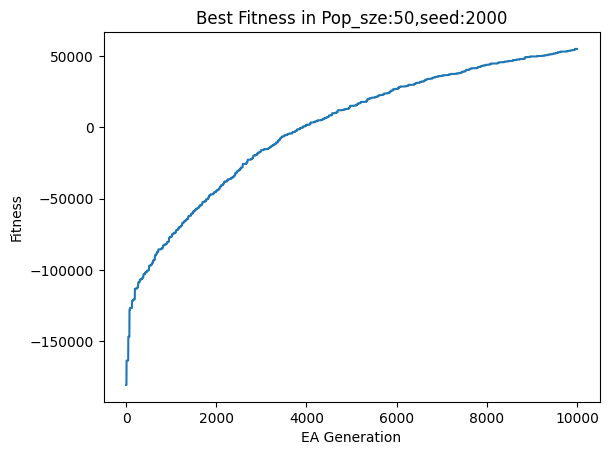

In [83]:
import matplotlib.pyplot as plt
x = range(len(Best150a))
plt.plot(x,Best150a)
# plt.plot(x,Best150b)
# plt.plot(x,Best150c)
# plt.plot(x,Best150d)
# plt.plot(x,Best150e)
print("Best Result",max(Best150a))
plt.title("Best Fitness in Pop_sze:50,seed:2000")
plt.xlabel("EA Generation")
plt.ylabel("Fitness")

# 4. Validation-function of Result for different algorithms
   1.check the beg's capacity 
   
   2.check the final profit with specific renting_ratio

In [80]:
# calculate distance_matrix
def dixtance_matrix(city_data):
    num_cities = len(city_data)
    distance_matrix = np.zeros((num_cities, num_cities))

    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                distance_matrix[i, j] = np.sqrt((city_data.iloc[i]['X'] - city_data.iloc[j]['X'])**2 + (city_data.iloc[i]['Y'] - city_data.iloc[j]['Y'])**2) 
    return distance_matrix   

def extract_section(file, start_marker, end_marker=None):
    """Extracts a section from the file starting from start_marker until end_marker, or the end of file if end_marker is None."""
    lines = []
    capture = False
    for line in file:
        if start_marker in line:
            capture = True
            continue
        if end_marker and end_marker in line:
            break
        if capture:
            lines.append(line.strip())
    return lines

def write_to_csv(filename, data, header):
    """Writes data to a CSV file."""
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        for row in data:
            writer.writerow(row.split())

def V_eval_time(tour, packing_plan, item_location,capacity_of_knapsack,max_speed,min_speed):
    total_weight = 0
    total_time = 0
    for i,city in enumerate(tour):
        current_weight = []
        items = item_location[i]
        if items:       
            current_weight = [packing_plan[item[0]-1]*item[2] for item in items]
            total_weight += sum(list(current_weight))
        speed = V_eval_speed(total_weight,capacity_of_knapsack,max_speed,min_speed)
        if i < len(tour)-1:
            total_time += D[i][i+1]/speed
        else:
            total_time += D[i][0]/speed
    return total_time

def V_eval_speed(total_weight,capacity_of_knapsack,max_speed,min_speed):
    if total_weight <= capacity_of_knapsack:
        Speed = (max_speed - (total_weight*(max_speed-min_speed)/capacity_of_knapsack))
    else:
        Speed = min_speed
    return Speed

def V_eval_profit(packing_plan, value_list):
    picked_values = np.multiply(packing_plan,value_list)
    profit = sum(picked_values)
    return profit

def V_eval_fitness(profit, time):
    fitness = profit - (renting_ratio*time)
    return fitness

In [81]:
import csv
import pandas as pd
# parameter_example:
#      route: [2,3,4,1,....]
#    kp_plan: [0,1,0,1,1,1,0,0,0,.....]
#   file_dir: "a280-n1395.txt"...
# return:
#    profit,totle_time_cost,total_value   
def validation_function(route,kp_plan,file_dir):
#   Open the text file
    with open(file_dir, "r") as f:
        lines = f.readlines()  
        f.seek(0)  # 重置文件指针到文件开头
        city_data = extract_section(f, 'NODE_COORD_SECTION', 'ITEMS SECTION')
        # Extract item information
        f.seek(0)  # Go back to the beginning of the file
        item_data = extract_section(f, 'ITEMS SECTION', None)
  
    dimension = int(lines[2].split(":")[1].strip())
    num_of_items = int(lines[3].split(":")[1].strip())
    knapsack_capacity = float(lines[4].split(":")[1].strip())
    min_speed = float(lines[5].split(":")[1].strip())
    max_speed = float(lines[6].split(":")[1].strip())
    renting_ratio = float(lines[7].split(":")[1].strip())
    # Write city data to a CSV file
    write_to_csv('city_data.csv', city_data, ['INDEX', 'X', 'Y'])
    city_data = pd.read_csv('city_data.csv')
    # Write item data to a CSV file
    write_to_csv('item_data.csv', item_data, ['index', 'profit', 'weight', 'city'])
    item_data = pd.read_csv('item_data.csv')
    
#   validate the validity of parameters
    if len(route)!= dimension:
        raise TypeError("parameter wrong：Wrong number of cities")
    if len(kp_plan)!= num_of_items:
        raise TypeError("parameter wrong：Wrong number of items")
    if sum(row[2] for i,row in item_data.iterrows() if kp_plan[i]==1) > knapsack_capacity:
        raise TypeError("the items overweight")
           
    distance_matrix=dixtance_matrix(city_data)

    item_location = []
    for i in range(dimension):
        rows = [row for j, row in item_data.iterrows() if row[3] - 1 == i]
        item_location.append(rows)
    total_time_cost =V_eval_time(route, kp_plan, item_location,knapsack_capacity,max_speed,min_speed)
    value_list=[row[1] for i,row in item_data.iterrows()]
    profit_of_items=V_eval_profit(kp_plan, value_list)
    final_fitness= V_eval_fitness(profit_of_items, total_time_cost)
    return final_fitness,total_time_cost,profit_of_items   

In [82]:
route=[253, 104, 208, 24, 275, 52, 135, 120, 73, 94, 244, 179, 174, 36, 200, 47, 264, 107, 133, 153, 77, 259, 145, 142, 139, 118, 12, 187, 95, 134, 136, 212, 137, 83, 171, 238, 279, 185, 87, 203, 269, 93, 184, 254, 211, 29, 144, 197, 173, 43, 40, 5, 222, 201, 207, 237, 101, 149, 123, 194, 224, 35, 241, 250, 44, 15, 216, 63, 164, 151, 271, 240, 34, 206, 10, 268, 257, 21, 128, 181, 175, 161, 221, 272, 243, 106, 219, 252, 165, 30, 265, 223, 225, 129, 152, 113, 215, 90, 245, 228, 114, 45, 111, 33, 0, 266, 121, 141, 105, 57, 249, 156, 25, 138, 233, 99, 188, 157, 41, 62, 189, 72, 28, 230, 143, 53, 278, 260, 102, 273, 92, 48, 69, 66, 218, 74, 49, 262, 183, 155, 91, 191, 177, 39, 169, 227, 214, 112, 261, 258, 163, 9, 131, 54, 67, 76, 11, 246, 50, 148, 19, 1, 270, 6, 85, 235, 196, 100, 158, 251, 23, 159, 226, 110, 46, 255, 79, 193, 274, 119, 190, 182, 68, 70, 14, 98, 51, 37, 150, 267, 32, 195, 88, 125, 55, 75, 256, 130, 232, 239, 3, 276, 103, 26, 124, 16, 17, 205, 97, 234, 82, 58, 204, 65, 186, 166, 248, 2, 162, 84, 7, 8, 56, 42, 109, 199, 59, 229, 170, 38, 146, 236, 89, 61, 86, 78, 71, 180, 27, 160, 140, 115, 18, 263, 202, 154, 220, 127, 13, 122, 22, 247, 147, 116, 167, 117, 242, 231, 81, 217, 64, 132, 198, 277, 209, 60, 108, 178, 192, 80, 172, 213, 210, 96, 4, 20, 126, 168, 31, 176]
kp_plan=[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]
 
# route=[146, 78, 138, 53, 93, 250, 188, 157, 155, 173, 126, 91, 71, 219, 199, 257, 136, 17, 79, 262, 165, 111, 168, 135, 174, 45, 263, 273, 204, 109, 150, 261, 84, 105, 122, 175, 240, 235, 5, 19, 110, 134, 156, 3, 51, 159, 161, 90, 116, 239, 127, 13, 196, 98, 142, 61, 124, 129, 14, 92, 213, 230, 277, 120, 66, 259, 44, 192, 24, 58, 131, 232, 228, 2, 73, 29, 171, 279, 6, 245, 275, 272, 201, 145, 121, 208, 167, 269, 76, 67, 177, 151, 268, 198, 197, 203, 276, 43, 169, 88, 65, 264, 118, 12, 258, 33, 21, 163, 180, 22, 94, 119, 234, 238, 46, 152, 27, 153, 9, 123, 220, 1, 50, 231, 54, 39, 57, 147, 42, 56, 7, 37, 60, 207, 266, 252, 255, 112, 48, 154, 83, 113, 108, 133, 247, 179, 139, 103, 244, 211, 182, 52, 162, 34, 212, 164, 265, 10, 160, 82, 233, 26, 75, 249, 8, 77, 251, 271, 237, 86, 99, 97, 223, 225, 63, 89, 191, 209, 102, 193, 216, 106, 96, 74, 28, 62, 100, 210, 117, 47, 64, 256, 31, 229, 0, 87, 101, 186, 176, 278, 217, 18, 243, 202, 166, 274, 128, 184, 132, 115, 221, 38, 11, 68, 200, 181, 36, 241, 59, 195, 267, 172, 69, 218, 254, 85, 95, 242, 143, 55, 222, 141, 35, 23, 70, 215, 158, 72, 185, 80, 125, 253, 30, 190, 81, 224, 130, 246, 107, 20, 183, 32, 140, 194, 248, 206, 49, 16, 178, 15, 148, 205, 189, 40, 170, 227, 4, 41, 236, 270, 104, 187, 260, 25, 214, 149, 144, 226, 137, 114]
# kp_plan=[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]

file_dir='a280-n1395.txt' # "a280-n279.txt"
final_fitness,total_time_cost,profit_of_items =validation_function(route,kp_plan,file_dir)
print('final_fitness:',final_fitness)
print('total_time_cost:',total_time_cost)
print('profit_of_items:',profit_of_items)

final_fitness: -35141.92425039841
total_time_cost: 4439.765120363114
profit_of_items: 287629
